# Predict tags on StackOverflow with linear models

In this assignment you will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.

### Data

The following cell will download all data required for this assignment into the folder `week1/data`.

### Text preprocessing

For this and most of the following assignments you will need to use a list of stop words. It can be downloaded from *nltk*:

In [85]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In this task you will deal with a dataset of post titles from StackOverflow. You are provided a split to 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). The *test* set is provided for Coursera's grading and doesn't contain answers. Upload the corpora using *pandas* and look at the data:

In [86]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [87]:
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data

In [88]:
train = read_data('data/train.tsv')
validation = read_data('data/validation.tsv')
test = pd.read_csv('data/test.tsv', sep='\t')

In [89]:
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


As you can see, *title* column contains titles of the posts and *tags* column contains the tags. It could be noticed that a number of tags for a post is not fixed and could be as many as necessary.

For a more comfortable usage, initialize *X_train*, *X_val*, *X_test*, *y_train*, *y_val*.

In [90]:
X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values
print(X_train[10])

Obtaining the object the java.lang.Class<T> object for a parameterized type without constructing the class in q_uestion?


One of the most known difficulties when working with natural data is that it's unstructured. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*, *"Flip*, etc. To prevent the problems, it's usually useful to prepare the data somehow. In this task you'll write a function, which will be also used in the other assignments. 

**Task 1 (TextPrepare).** Implement the function *text_prepare* following the instructions. After that, run the function *test_test_prepare* to test it on tiny cases and submit it to Coursera.

In [91]:
import re

In [92]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    #Note: Would it be better to replace with " " and after all substitutions remove consecutive spaces with one.
    text = text.lower()# lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) #replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub("",text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = text.replace("  "," ")
    text_list = list(text.split())
    temp = ""
    for i in text_list:
        if(i not in STOPWORDS):
            temp = temp + " " + i
    text = temp.lstrip()# delete stopwords from text
    return text

In [93]:
def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        print(ans)
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [94]:
print(test_text_prepare())

sql server equivalent excels choose function
free c++ memory vectorint arr
Basic tests are passed.


Run your implementation for questions from file *text_prepare_tests.tsv* to earn the points.

In [95]:
prepared_questions = []
for line in open('data/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    #print(line)
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)

grader.submit_tag('TextPrepare', text_prepare_results)

Current answer for task TextPrepare is:
 sqlite php readonly
creating multiple textboxes dynamically
self one prefer javascript
save php date...


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [96]:
X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]

In [97]:
X_train[:3]
print(X_train[:3],y_train[:3])
(y_train[1][0])

['draw stacked dotplot r', 'mysql select records datetime field less specified value', 'terminate windows phone 81 app'] [list(['r']) list(['php', 'mysql']) list(['c#'])]


'php'

For each tag and for each word calculate how many times they occur in the train corpus. 

**Task 2 (WordsTagsCount).** Find 3 most popular tags and 3 most popular words in the train data and submit the results to earn the points.

In [98]:
# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}

def popular_word_count(input_list):
    processing_dict = {}
    for i in range(len(input_list)):
        input_s = []
        input_s = list(input_list[i].split())
        for j in range(len(input_s)):
            if input_s[j] not in processing_dict:
                processing_dict[input_s[j]] = 1
            else:
                processing_dict[input_s[j]] = processing_dict[input_s[j]] + 1
    return processing_dict
words_counts = popular_word_count(X_train)

def popular_tag_count(input_list):
    processing_dict = {}
    for i in range(len(input_list)):
        for j in range(len(input_list[i])):
            if input_list[i][j] not in processing_dict:
                processing_dict[input_list[i][j]] = 1
            else:
                processing_dict[input_list[i][j]] += 1
    return processing_dict

tags_counts = popular_tag_count(y_train)

print(words_counts['java'])

5501


In [100]:
DICT_SIZE = 5000
most_common_words = [word for word, _ in (sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE])]
WORDS_TO_INDEX = {}
INDEX_TO_WORDS = {}
ALL_WORDS = WORDS_TO_INDEX.keys()

def build_dictionaries(words):
    words_to_index = {}
    index_to_words = {}
    no_of_words = 0
    for i in words:
        words_to_index[i] = no_of_words
        index_to_words[no_of_words] = i
        no_of_words = no_of_words + 1
    return words_to_index, index_to_words
WORDS_TO_INDEX, INDEX_TO_WORDS = build_dictionaries(most_common_words)

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size,dtype = int)
    for word in text.split():
        if word in words_to_index:
            index = words_to_index[word]
            result_vector[index] = result_vector[index]+1
    return result_vector

#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Implement function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Use *train* corpus to train a vectorizer. Don't forget to take a look into the arguments that you can pass to it. We suggest that you filter out too rare words (occur less than in 5 titles) and too frequent words (occur more than in 90% of the titles). Also, use bigrams along with unigrams in your vocabulary. 

Let us Build first pipeline using LogisticRegression
We will use Gridsearch and Cross validation to find the best parameters and test on the test set.
We will repeat the process using SVM as estimator

In [174]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

In [175]:
def logisticRegressionPipe():
    logit_pipe = [('vect',TfidfVectorizer(max_df = 0.9, min_df = 5,ngram_range = (1,2), token_pattern = '(\S+)')),
                  ('logit',OneVsRestClassifier(LogisticRegression()))]
    pipe = Pipeline(logit_pipe)
    param_grid = dict(logit__estimator__C=[5, 10, 100])
    score = 'f1_weighted'

    print("# Tuning hyper-parameters for %s" % score)
    print()
    grid_search = GridSearchCV(pipe, param_grid=param_grid,cv = 5,scoring='f1_weighted')
    y_train_binary = MultiLabelBinarizer(classes=sorted(tags_counts.keys())).fit_transform(y_train)
    grid_search.fit(X_train,y_train_binary)
    print("Best parameters set found on development set:")
    print()
    print(grid_search.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = MultiLabelBinarizer(classes=sorted(tags_counts.keys())).fit_transform(y_val), grid_search.predict(X_val)
    print(classification_report(y_true, y_pred))
    print()

In [176]:
logisticRegressionPipe()

# Tuning hyper-parameters for f1_weighted

Best parameters set found on development set:

{'logit__estimator__C': 10}

Grid scores on development set:

0.645 (+/-0.004) for {'logit__estimator__C': 5}
0.649 (+/-0.004) for {'logit__estimator__C': 10}
0.623 (+/-0.004) for {'logit__estimator__C': 100}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.37      0.10      0.15      1145
          1       0.81      0.46      0.59       573
          2       0.67      0.14      0.23       146
          3       0.93      0.58      0.72       898
          4       0.97      0.81      0.88       409
          5       0.56      0.23      0.33       144
          6       0.54      0.36      0.43       640
          7       0.78      0.39      0.52      1150
          8       0.66      0.31      0.42       381
          9       0.83      0.53 

In [167]:
from sklearn import svm

In [177]:
def SVMPipe():
    svm_pipe = [('vect',TfidfVectorizer(max_df = 0.9, min_df = 5,ngram_range = (1,2), token_pattern = '(\S+)')),
                  ('svm_estimator',OneVsRestClassifier(svm.LinearSVC()))]
    pipe = Pipeline(svm_pipe)

    param_grid = dict(svm_estimator__estimator__C=[0.01,0.1,1])
    score = 'f1_weighted'

    print("# Tuning hyper-parameters for %s" % score)
    print()
    grid_search = GridSearchCV(pipe, param_grid=param_grid,cv = 5,scoring='f1_weighted')
    y_train_binary = MultiLabelBinarizer(classes=sorted(tags_counts.keys())).fit_transform(y_train)
    grid_search.fit(X_train,y_train_binary)
    print("Best parameters set found on development set:")
    print()
    print(grid_search.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = grid_search.cv_results_['mean_test_score']
    stds = grid_search.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, grid_search.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = MultiLabelBinarizer(classes=sorted(tags_counts.keys())).fit_transform(y_val), grid_search.predict(X_val)
    print(classification_report(y_true, y_pred))
    print()

In [178]:
SVMPipe()

# Tuning hyper-parameters for f1_weighted



/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:113

Best parameters set found on development set:

{'svm_estimator__estimator__C': 1}

Grid scores on development set:

0.419 (+/-0.004) for {'svm_estimator__estimator__C': 0.01}
0.616 (+/-0.005) for {'svm_estimator__estimator__C': 0.1}
0.657 (+/-0.005) for {'svm_estimator__estimator__C': 1}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

             precision    recall  f1-score   support

          0       0.45      0.08      0.14      1145
          1       0.81      0.50      0.62       573
          2       0.66      0.14      0.24       146
          3       0.94      0.59      0.73       898
          4       0.97      0.82      0.89       409
          5       0.57      0.26      0.35       144
          6       0.53      0.38      0.44       640
          7       0.81      0.40      0.54      1150
          8       0.67      0.34      0.45       381
          9       0.83      0.52      0.64 

In [158]:
predicted = grid_search.predict(X_val)
y_val_binary = MultiLabelBinarizer(classes=sorted(tags_counts.keys())).fit_transform(y_val)
f1_score_weighted = f1_score(y_val_binary,predicted,average = 'weighted')
print(f1_score_weighted)

0.654022818733


In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [104]:
def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    m_vectorizer = TfidfVectorizer(max_df = 0.9, min_df = 5,ngram_range = (1,2), token_pattern = '(\S+)')
    
    tfidf_vectorizer = m_vectorizer.fit(X_train)
    X_train = tfidf_vectorizer.transform(X_train)
    X_val = tfidf_vectorizer.transform(X_val)
    X_test = tfidf_vectorizer.transform(X_test)
    #print(tfidf_vectorizer.stop_words_)
    
    return X_train, X_val, X_test, m_vectorizer.vocabulary_

### MultiLabel classifier

As we have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [115]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

In [144]:
estimators = [('vect',TfidfVectorizer(max_df = 0.9, min_df = 5,ngram_range = (1,2), token_pattern = '(\S+)')),
              ('logit',OneVsRestClassifier(LogisticRegression()))]
pipe = Pipeline(estimators)
y_train_binary = MultiLabelBinarizer(classes=sorted(tags_counts.keys())).fit_transform(y_train)
pipe.fit(X_train,y_train_binary)
predicted = pipe.predict(X_val)

In [146]:
y_val_binary = MultiLabelBinarizer(classes=sorted(tags_counts.keys())).fit_transform(y_val)
f1_score_weighted = f1_score(y_val_binary,predicted,average = 'weighted')
print(f1_score_weighted)

0.0


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [145]:
pipe.set_params(logit__estimator__C = 0.001)
pipe.fit(X_train,y_train_binary)
predicted = pipe.predict(X_val)

In [59]:
mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train = mlb.fit_transform(y_train)
y_val = mlb.fit_transform(y_val)

Implement the function *train_classifier* for training a classifier. In this task we suggest to use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [124]:
def train_classifierA(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    m_logit = LogisticRegression(penalty = 'l1',C = 100)
    m_ovr = OneVsRestClassifier(m_logit)
    m_classifier = m_ovr.fit(X_train,y_train)
    return m_classifier

In [ ]:
def train_classifierB(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
    m_logit = LogisticRegression(penalty = 'l1',C = 100)
    m_ovr = OneVsRestClassifier(m_logit)
    m_classifier = m_ovr.fit(X_train,y_train)
    return m_classifier

In [125]:

classifier_tfidf = train_classifier(X_train_tfidf, y_train)

Now you can create predictions for the data. You will need two types of predictions: labels and scores.

Now take a look at how classifier, which uses TF-IDF, works for a few examples:

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [130]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [134]:
from metrics import roc_auc
%matplotlib inline

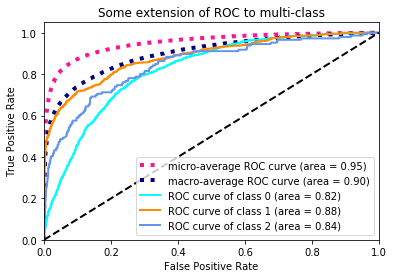

In [135]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_mybag, n_classes)

In [ ]:
n_classes = len(tags_counts)
roc_auc(y_val, y_val_predicted_scores_tfidf, n_classes)

**Task 4 (MultilabelClassification).** Once we have the evaluation set up, we suggest that you experiment a bit with training your classifiers. We will use *F1-score weighted* as an evaluation metric. Our recommendation:
- compare the quality of the bag-of-words and TF-IDF approaches and chose one of them.
- for the chosen one, try *L1* and *L2*-regularization techniques in Logistic Regression with different coefficients (e.g. C equal to 0.1, 1, 10, 100).

You also could try other improvements of the preprocessing / model, if you want. 

Implement the function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [ ]:
def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
    
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    top_positive_words = # top-5 words sorted by the coefficiens.
    top_negative_words = # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))

In [ ]:
print_words_for_tag(classifier_tfidf, 'c', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'linux', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)